# District information in Slovakia
The aim of this notebook is to generate graphs for inter-district migration is Slovak districts

In [220]:
import os
import pandas as pd
import geopandas
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown

## Net migration map
- Creates a map of districts and their population change

In [221]:
net_migration_raw = pd.read_csv("../../Data/slovakia/net_migration_districts_sk.csv")

districts_geodata = geopandas.read_file("../../Data/geography/slovak_districts.json")

# display(net_migration_raw.head())
# display(districts_geodata.head())

districts_net_migration = pd.merge(districts_geodata,net_migration_raw,on="LAU1_CODE")

display(districts_net_migration.head())

,LAU1,DOW,IDN3,NM3,IDN2,NM2,NUTS2,NUTS2_CODE,NUTS3,NUTS3_CODE,...,2003,2002,2001,2000,1999,1998,1997,1996,1995,1993
0,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,...,-109,-14,67,4,11,-166,-19,149,242,6
1,Banská Štiavnica,2021-02-26 00:00:00+00:00,602,Banská Štiavnica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,...,10,39,26,15,46,97,100,-18,22,-7
2,Bardejov,2021-02-26 00:00:00+00:00,701,Bardejov,7,Prešovský,Východné Slovensko,SK04,Prešovský kraj,SK041,...,-93,-85,-79,-96,-63,-79,-52,-12,-47,75
3,Bratislava I,2021-02-26 00:00:00+00:00,101,Bratislava I,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,...,-329,-238,-169,-43,-157,-240,-169,126,271,-3
4,Bratislava II,2021-02-26 00:00:00+00:00,102,Bratislava II,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,...,340,219,218,157,-150,-35,55,226,128,293


In [222]:
print(districts_net_migration.columns)

Index(['LAU1', 'DOW', 'IDN3', 'NM3', 'IDN2', 'NM2', 'NUTS2', 'NUTS2_CODE',
       'NUTS3', 'NUTS3_CODE', 'LAU1_CODE', 'LAU2', 'LAU2_CODE', 'geometry',
       '2024', '2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016',
       '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007',
       '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998',
       '1997', '1996', '1995', '1993'],
      dtype='object')


#### Largest/smallest value in counties

In [223]:
def district_value_total(table,ascending = True):
    data = []
    
    for index,row in table.iterrows():
        name = row["NM3"]
        geography = row["geometry"]
        total = 0
        for year in range(1995,2024,1):
            total += row[str(year)]

        data.append({"District":name,
                     "geometry":geography,
                     "value":total})
    result_df = geopandas.GeoDataFrame(data)
    result_df.sort_values(by="value",ascending=ascending,inplace=True)
    # display(result_df.head())
    return result_df

# district_value_total(districts_net_migration,ascending=False)

#### Creating drawing function

In [307]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_districts(table, target_column, title_label="", colorbar_label="Value",fixed_max_value=None,filename="",has_negative = True,color_scheme = ["red", "lightgray", "green"],biggest_text="Biggest net gain",smallest_text = "Biggest net loss"):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if fixed_max_value is None:
        max_value = max([abs(x) for x in table[target_column]])
        # print("Max value: ",max_value)
    else:
        max_value = fixed_max_value
    

    cmap = LinearSegmentedColormap.from_list("red_green", color_scheme)
    if has_negative:
        norm = Normalize(vmin=-max_value, vmax=max_value)
    else:

        norm = Normalize(vmin=0,vmax=max_value)

    # axes = table.plot(column = target_column,legend=True,cmap=cmap,norm=norm,edgecolor="gray",linewidth=0.3)

    table.plot(
        column=target_column,
        cmap=cmap,
        norm=norm,
        edgecolor="gray",
        linewidth=0.3,
        ax=ax,
        legend=False
    )

    # I used ChatGPT to write this paragraph of code
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label(colorbar_label, fontsize=10)


    ax.set_title(title_label, fontsize=18,  pad=15)
    ax.set_axis_off()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    #Net gain and loss
    gain_table = table.sort_values(str(target_column),ascending=False).head()
    
    loss_table = table.sort_values(str(target_column),ascending=False).tail()

    #constant, change here:
    n_districts = 5
    gain = []
    loss = []
    
    for i in range(n_districts):
        gain.append((gain_table.iloc[i,0],int(gain_table.iloc[i,:][str(target_column)])))
        loss.append((loss_table.iloc[i,0],int(loss_table.iloc[i,:][str(target_column)])))
    
    gain_text = rf"$\bf { "\\ ".join(biggest_text.split())}$"+"\n"

    for district,value in gain:
        gain_text += district + ": "+ str(float(value)) + "\n"
    
    loss_text = rf"$\bf {"\\ ".join(smallest_text.split())}$"+"\n"
    for district,value in loss:
        loss_text += district + ": "+ str(float(value)) + "\n"

    plt.figtext(0.4, 0.1, gain_text, ha='left', fontsize=9, wrap=False)
    plt.figtext(0.6, 0.1, loss_text, ha='left', fontsize=9, wrap=False)

    plt.tight_layout()
    if filename != "":
        # os.makedirs("../../Images/Slovakia",exist_ok=True)
        plt.savefig("../../Images/Slovakia/"+filename+".png")
        plt.close()
    else:
        plt.show()

# draw_districts(districts_net_migration, str(2020), title_label="District migration in "+str(2020), colorbar_label="Total migration change",filename="")


#### Drawing multiple maps

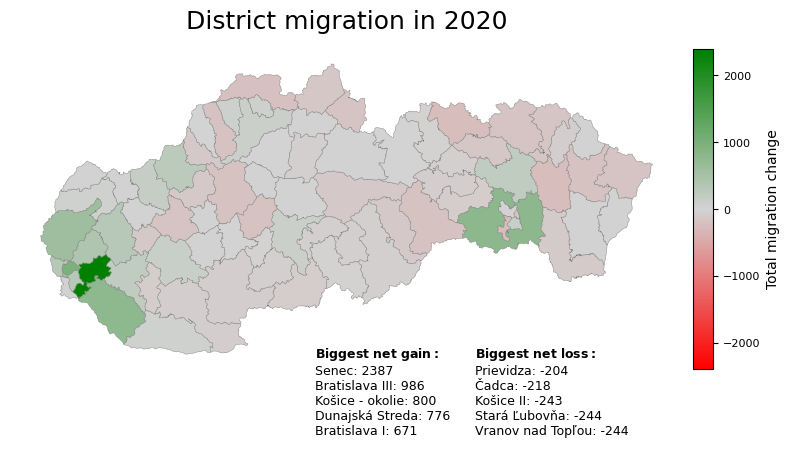

In [225]:
# for year in range(1995,2024,1):
#     draw_districts(districts_net_migration, str(year), title_label="District migration in "+str(year), colorbar_label="Total migration change",fixed_max_value=None,filename="Migration/Relative/district_migration_change_"+str(year))

# for year in range(1995,2024,1):
#     draw_districts(districts_net_migration, str(year), title_label="District migration in "+str(year), colorbar_label="Total migration change",fixed_max_value=3000,filename="Migration/Uniform/uniform_district_migration_change_"+str(year))

# draw_districts(districts_net_migration, str(1993), title_label="District migration in "+str(1993), colorbar_label="Total migration change",fixed_max_value=None,filename="Migration/Relative/district_migration_change_"+str(1993))
# draw_districts(districts_net_migration, str(1993), title_label="District migration in "+str(1993), colorbar_label="Total migration change",fixed_max_value=3000,filename="Migration/Uniform/uniform_district_migration_change_"+str(1993))


draw_districts(districts_net_migration, str(2020), title_label="District migration in "+str(2020), colorbar_label="Total migration change",filename="")


#### Drawing total change


In [226]:
#Total change
total_table = district_value_total(districts_net_migration,True)
display(total_table.head())
# draw_districts(total_table,target_column="value",title_label="Total district migration from 1995 to 2023",colorbar_label="Total migration change",filename="total_district_change.png")

,District,geometry,value
7,Bratislava V,"POLYGON ((-568838.92 -1291406.77, -568471.28 -...",-17699
24,Košice III,"POLYGON ((-257734.5 -1238885.75, -257766 -1238...",-7257
23,Košice II,"POLYGON ((-266711.3 -1248792.99, -265963.61 -1...",-7187
60,Spišská Nová Ves,"POLYGON ((-313920.46 -1226105.61, -313841.21 -...",-5400
17,Humenné,"POLYGON ((-209754.12 -1227503.03, -209734.27 -...",-5350


### Most immigration/emigration districts

In [227]:
# display(Markdown("### Districts with biggest net gain in 2023"))
# display(districts_net_migration.sort_values("2023",ascending=False).head())

# display(Markdown("### Districts with biggest net loss in 2023"))
# display(districts_net_migration.sort_values("2023",ascending=True).head())


## Unemployment

#### Creating table

In [272]:
unemployment_migration_raw = pd.read_csv("../../Data/slovakia/unemployment_districts_sk.csv")

districts_unemployment = pd.merge(districts_geodata,unemployment_migration_raw,on="LAU1_CODE")

display(districts_unemployment.head())

,LAU1,DOW,IDN3,NM3,IDN2,NM2,NUTS2,NUTS2_CODE,NUTS3,NUTS3_CODE,...,2009,2008,2007,2006,2005,2004,2003,2002,2 001.00,2001
0,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,...,8.43,4.40,4.33,5.54,7.40,8.68,10.72,10.55,11.44,11.44
1,Banská Štiavnica,2021-02-26 00:00:00+00:00,602,Banská Štiavnica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,...,16.92,14.89,13.36,15.43,18.18,17.33,19.98,19.93,20.37,20.37
2,Bardejov,2021-02-26 00:00:00+00:00,701,Bardejov,7,Prešovský,Východné Slovensko,SK04,Prešovský kraj,SK041,...,22.00,15.75,13.01,14.05,15.96,17.38,19.98,24.05,23.40,23.40
3,Bratislava I,2021-02-26 00:00:00+00:00,101,Bratislava I,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,...,2.71,1.46,1.56,1.77,2.04,2.58,3.67,4.85,6.15,6.15
4,Bratislava II,2021-02-26 00:00:00+00:00,102,Bratislava II,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,...,4.00,1.87,1.56,1.85,2.07,2.87,2.96,3.62,3.79,3.79


#### Drawing multiple maps

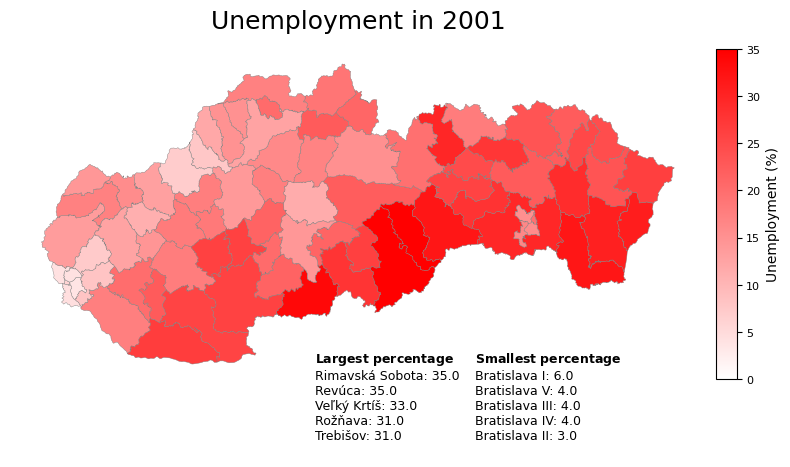

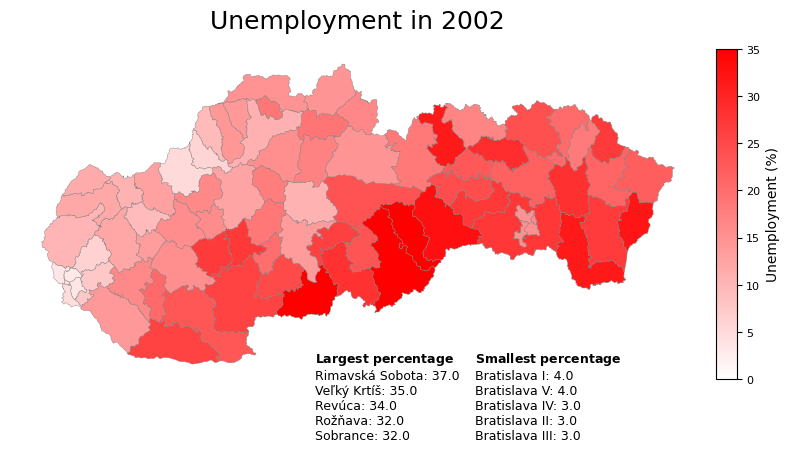

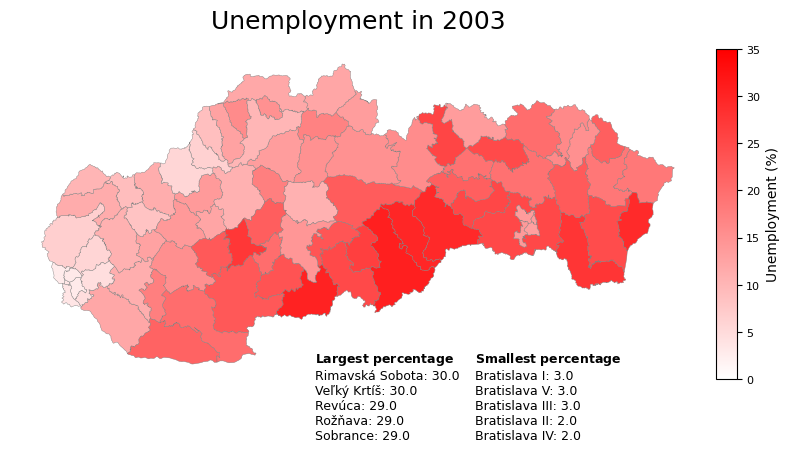

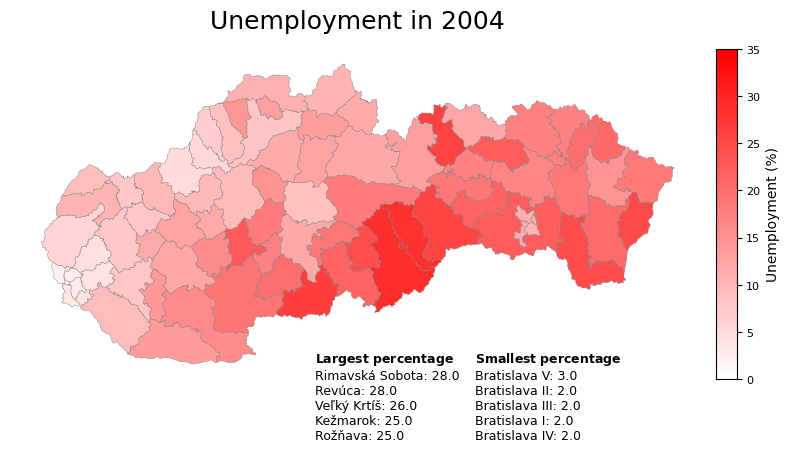

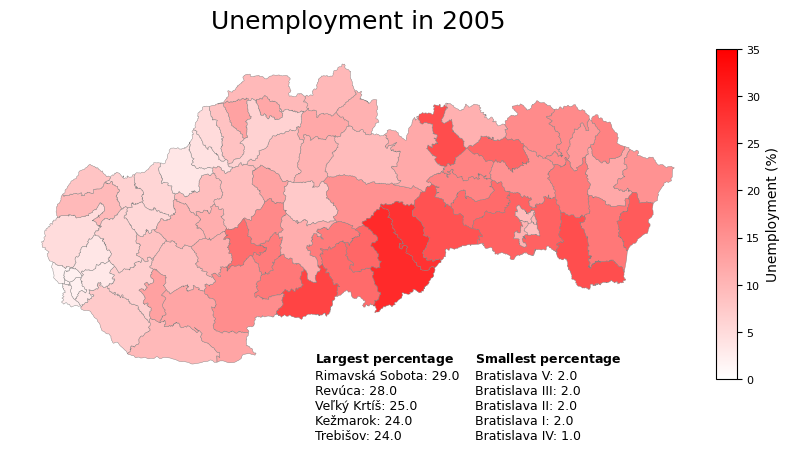

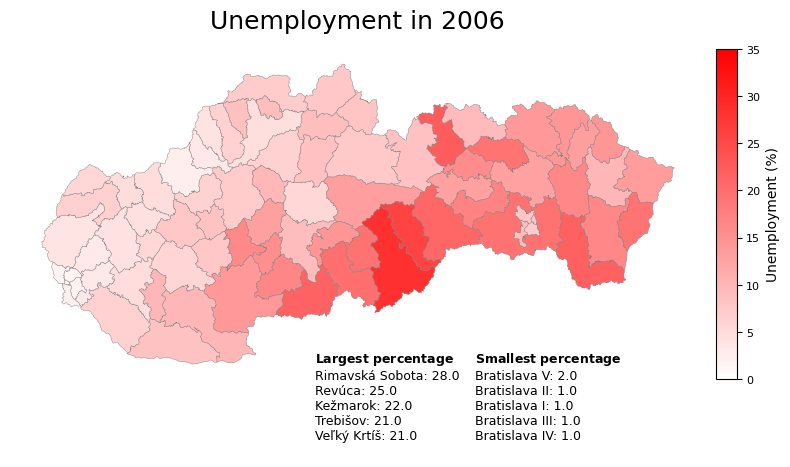

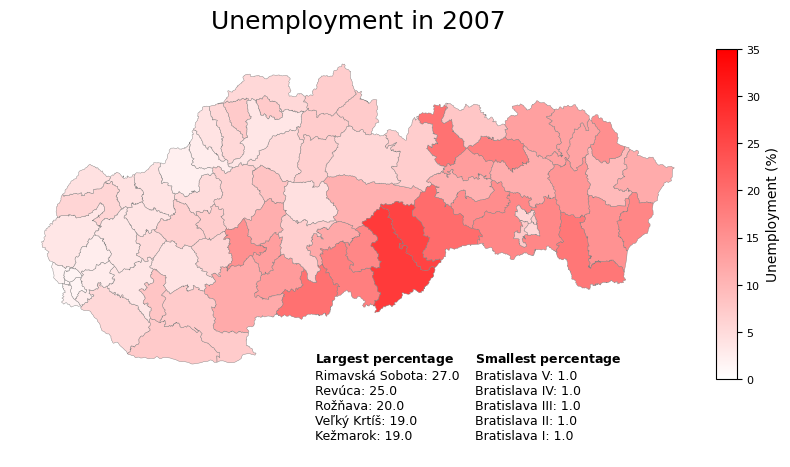

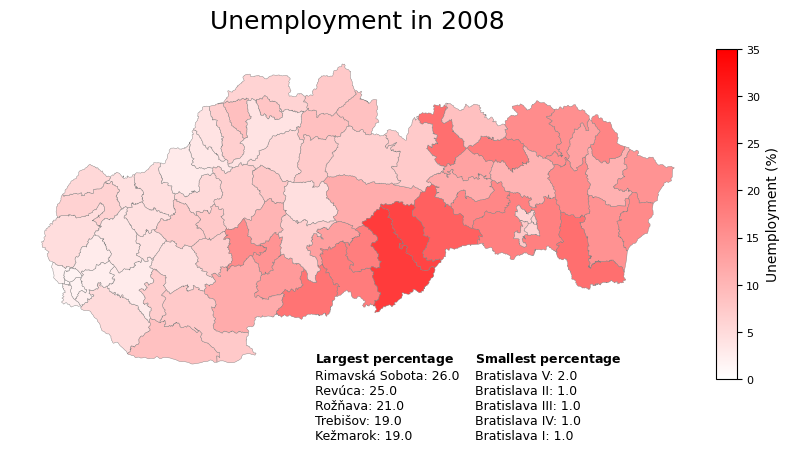

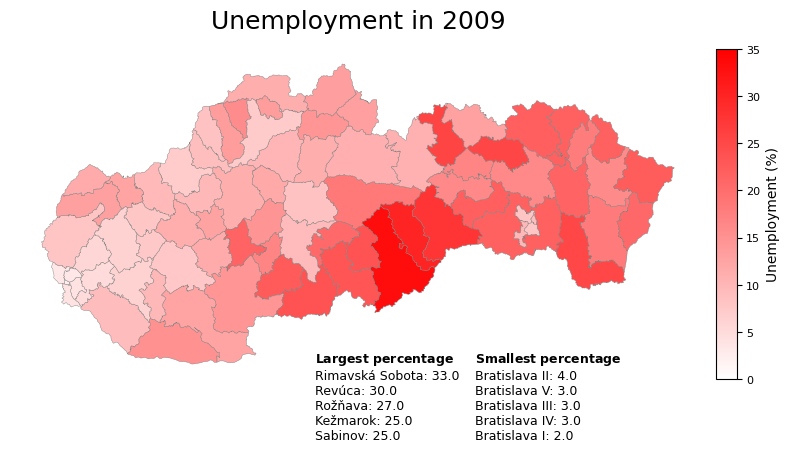

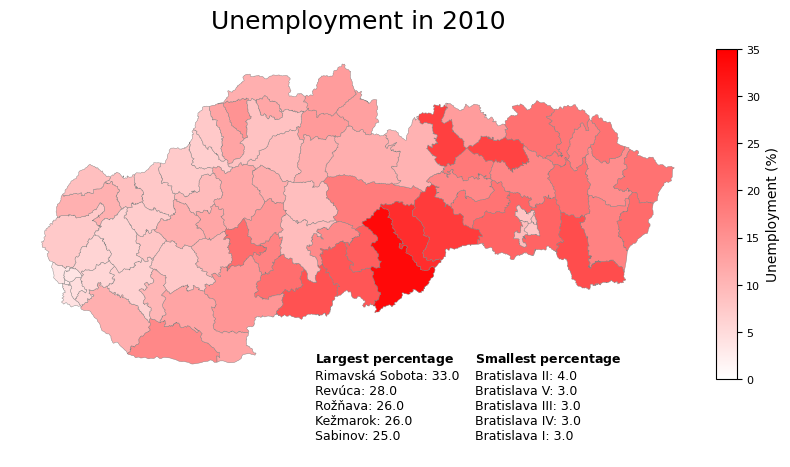

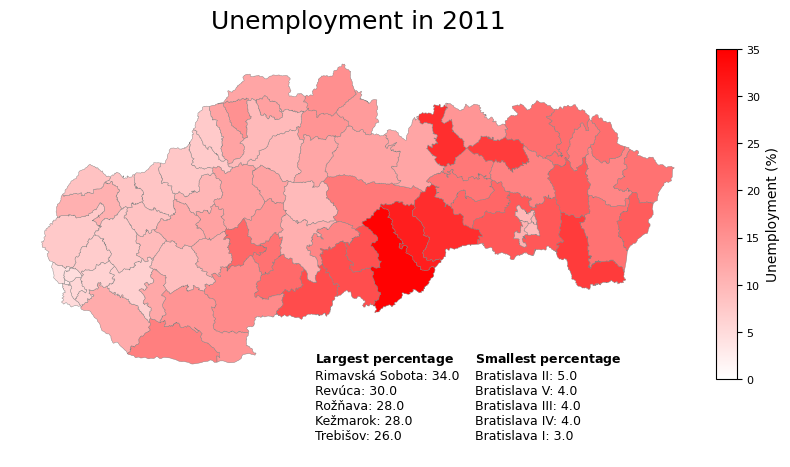

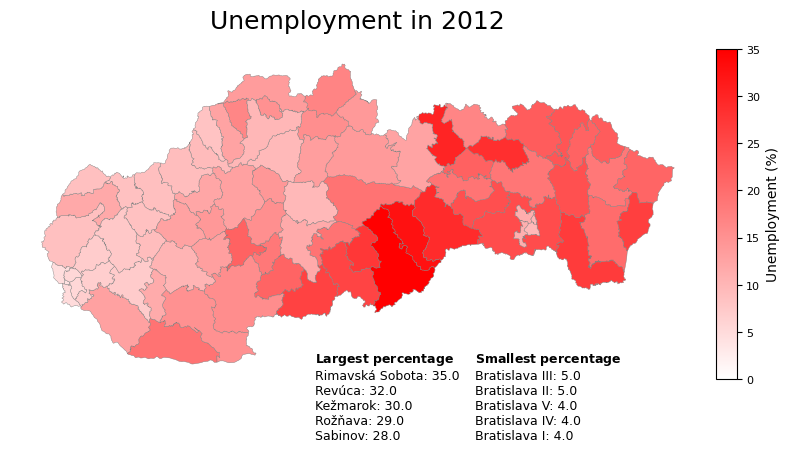

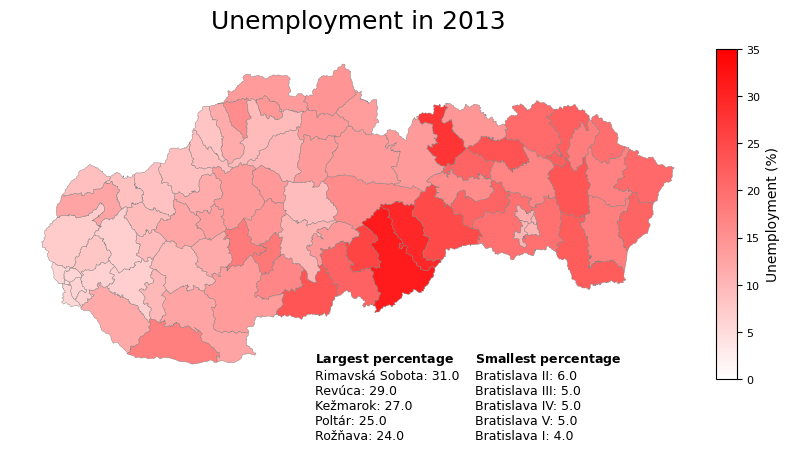

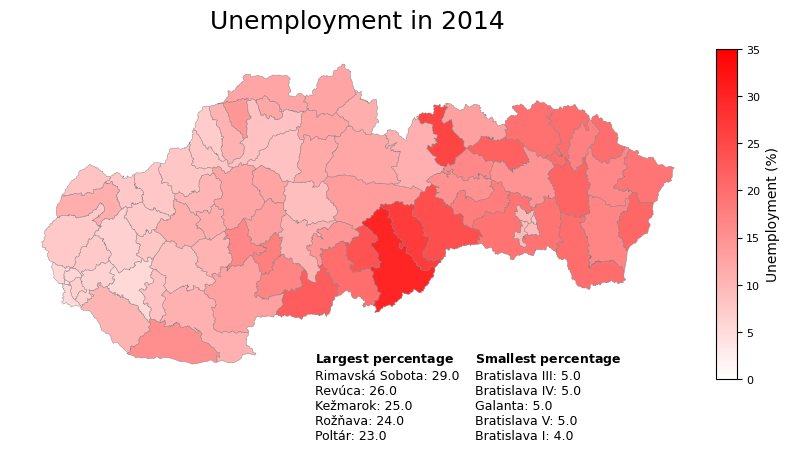

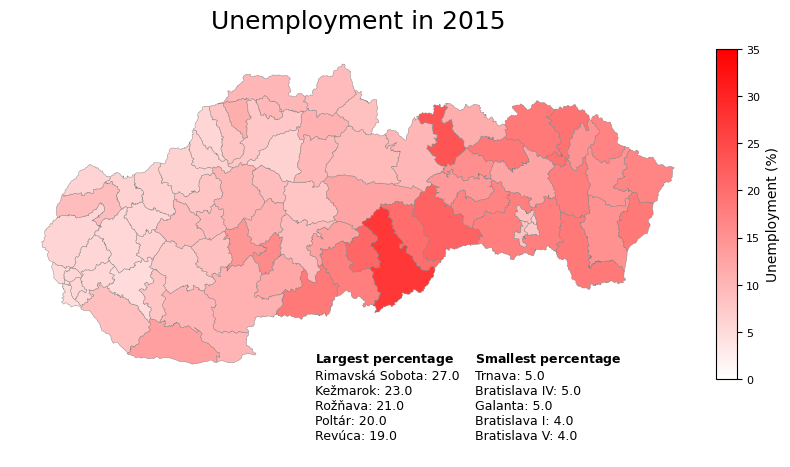

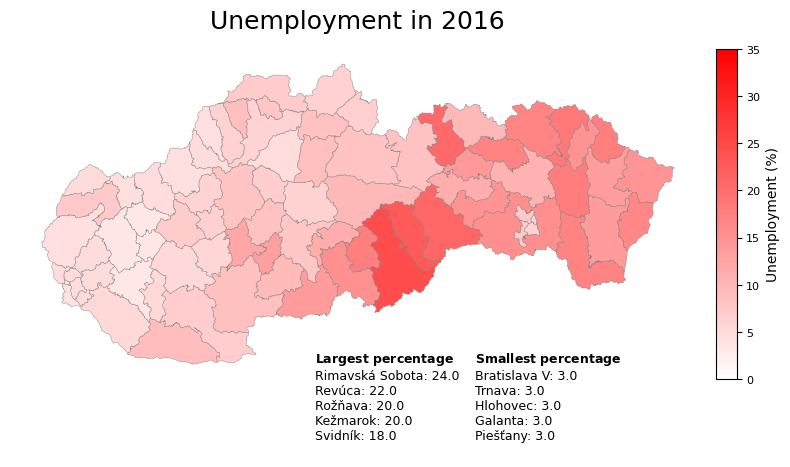

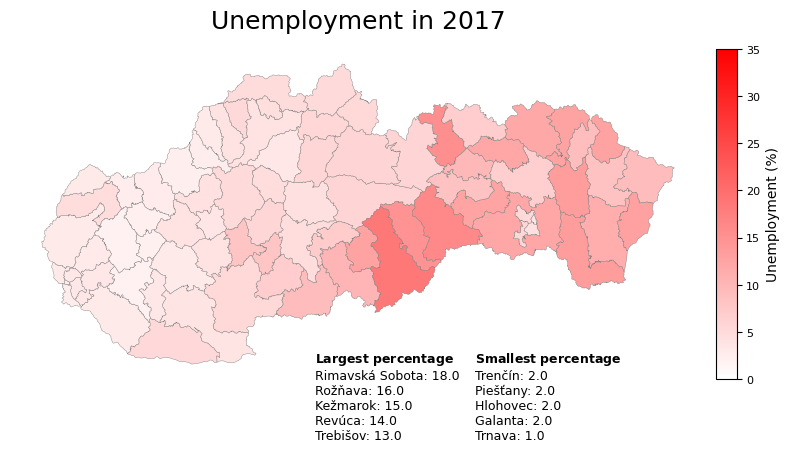

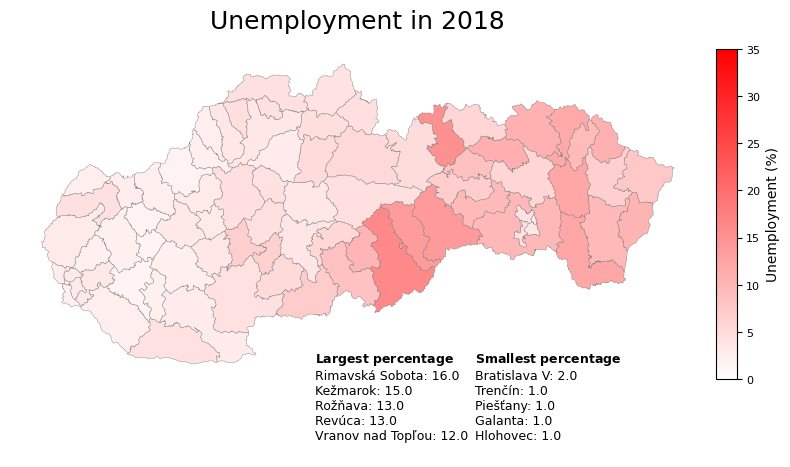

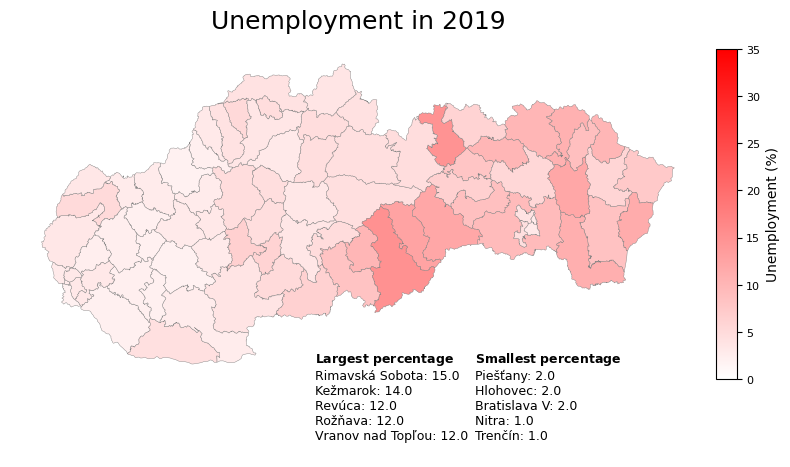

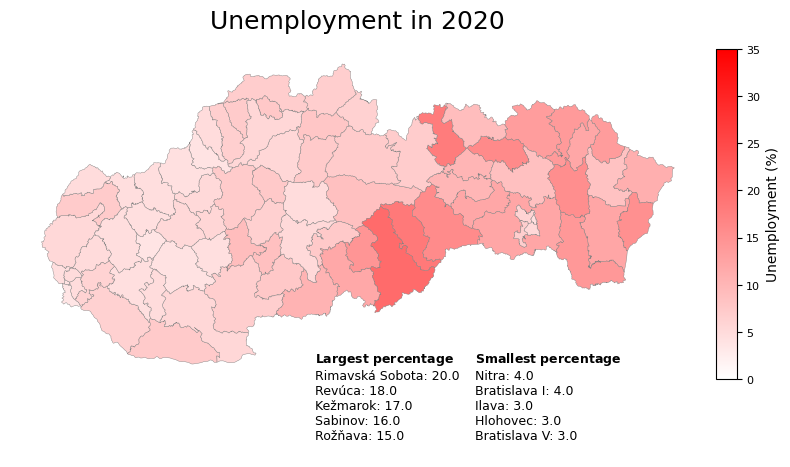

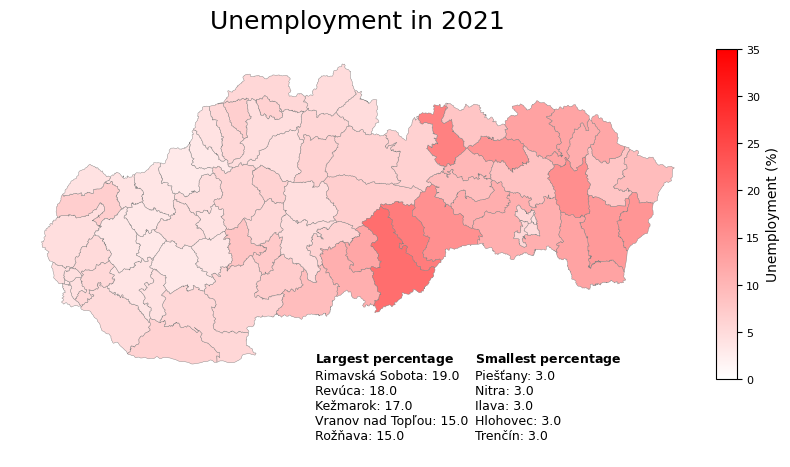

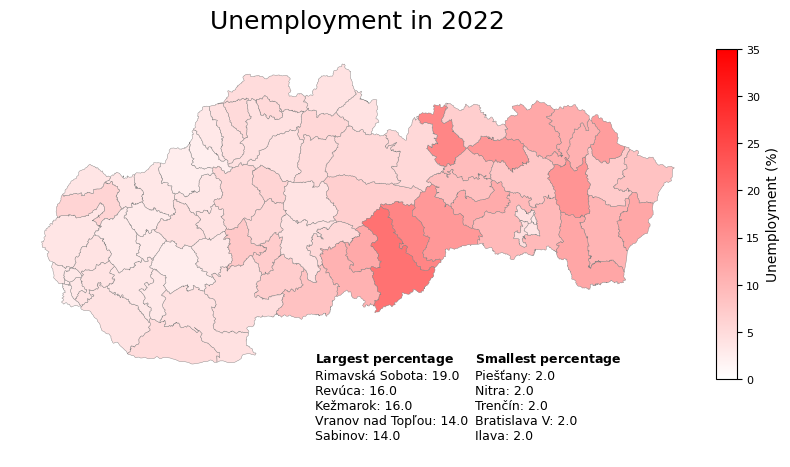

In [ ]:
# for year in range(2001,2023,1):
#     draw_districts(districts_unemployment, str(year), title_label="Unemployment in "+str(year), 
#                    colorbar_label="Unemployment (%)",filename="/Economy/Relative/district_unemployment_"+str(year)+".png",has_negative=False,color_scheme=["white","red"],
#                    biggest_text="Largest percentage",
#                    smallest_text="Smallest percentage")
for year in range(2001,2023,1):
    draw_districts(districts_unemployment, str(year), title_label="Unemployment in "+str(year), 
                   colorbar_label="Unemployment (%)",filename="/Economy/Uniform/uniform_district_unemployment_"+str(year)+".png",has_negative=False,color_scheme=["white","red"],
                   biggest_text="Largest percentage",
                   smallest_text="Smallest percentage",fixed_max_value=35)
    # draw_districts(districts_unemployment, str(year), title_label="Unemployment in "+str(year), 
    #                colorbar_label="Unemployment (%)",has_negative=False,color_scheme=["white","red"],
    #                biggest_text="Largest percentage",
    #                smallest_text="Smallest percentage",fixed_max_value=35,filename="")
# draw_districts(districts_unemployment, str(2020), title_label="Unemployment in "+str(2020), 
#                    colorbar_label="Unemployment (%)",has_negative=False,color_scheme=["white","red"],
#                    biggest_text="Largest percentage",
#                    smallest_text="Smallest percentage",fixed_max_value=35)
